# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

sns.set_style('whitegrid')

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### Display Data
Show the first five rows of each dataset

#### Portfolio Dataset

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


#### Profile Dataset

In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


#### Transcript Dataset

In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Data Completeness
Show how missing values in each dataset

#### Portfolio Dataset

In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

#### Profile Dataset

In [6]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

#### Transcript Dataset

In [7]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

As shown above, there is no missing values in `porfolio` and `transcript` datasets while `profile` dataset has a big number of missing values.

### Descriptive Statistics of Data
Show the Summary Statistics of each dataset

#### Portfolio Dataset

In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


#### Profile Dataset

In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


#### Transcript Dataset

In [10]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


According to summary statistics of all datasets, `portfolio` has an average of offer duration by 6.5 days, `profile` locates 64K for median of person and 714 Hours is the maximum of time since the test started in `transcript`.

### Data Types
Show the data types of features in each dataset

#### Portfolio Dataset

In [11]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


#### Profile Dataset

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


#### Transcript Dataset

In [13]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


From the above, it seems most of all colums are in correct type except `became_member_on` to be in `datetime`.

### Data Shape
Display the shape of each dataset

#### Portfolio Dataset

In [14]:
portfolio.shape

(10, 6)

#### Profile Dataset

In [15]:
profile.shape

(17000, 5)

#### Transcript Dataset

In [16]:
transcript.shape

(306534, 4)

### Data Cleaning & EDA

#### Get The Dictionary of Offer and Person IDs

In [17]:
# get unique ids of offer
offer_ids = np.array(list(set(portfolio.id.to_list())))

# get unique ids of profile
profile_ids = np.array(list(set(profile.id.to_list())))


# cast nd array to dictionary
offer_ids_dict = dict(enumerate(offer_ids.flatten(), 1))
profile_ids_dict = dict(enumerate(profile_ids.flatten(), 1))

#### Fix The Incorrect Values of Columns

##### Portfolio Dataset

In [80]:
# get value of channels column
channels_data = portfolio.channels.values

# cast nd array to list
channels_list = list(itertools.chain(*channels_data))

# get a unique list of channels values
cleaned_channels_list = list(set(channels_list))

In [81]:
for item in cleaned_channels_list:
    portfolio.insert(2,'is_'+item+'_channel',portfolio.channels.apply(lambda x: 1 if item in x else 0))

In [82]:
# drop a column
portfolio.drop(['channels'],axis=1,inplace=True)

In [83]:
portfolio.head()

,reward,is_web_channel,is_mobile_channel,is_social_channel,is_email_channel,difficulty,duration,offer_type,id
0,10,0,1,1,1,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,1,1,1,1,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,1,1,0,1,0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,1,1,0,1,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,1,0,0,1,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


##### Profile Dataset

In [84]:
# cast became_member_on from int to datatime with format (yyyy-mm-dd)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [85]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


##### Transcript Dataset

In [86]:
# get offers which are completed or received because the other events are extra
transcript = transcript.loc[transcript.event.isin(['offer completed', 'offer received'])]

In [87]:
# get offer_id from column value after parsing dictionary
transcript['offer_id'] = transcript.value.apply(lambda x: list(x.values())[0])

In [88]:
# get completed offers as dataframe with person and offer as columns 
completed_offer = transcript[transcript.event == 'offer completed' ][['person','offer_id']]

# get indexs of incompleted offers by using logical_not function 
incompleted_offer_idx = np.logical_not(transcript.person.isin(completed_offer.person) & transcript.offer_id.isin(completed_offer.offer_id))

In [89]:
# update the value of events to incompleted due to event status 
transcript.loc[incompleted_offer_idx,'event'] = 'offer incompleted'

# remove the duplicated rows since now offer status of the received likes the completed
transcript = transcript[transcript.event != 'offer received']

In [90]:
# drop colmun value since offer_id parsed
transcript.drop(['value'],axis=1,inplace=True)

# add new column reward from portfolio dataset after finding offer_id
transcript['reward'] = transcript.offer_id.apply(lambda x: portfolio.loc[portfolio.id.isin([x])].reward.values[0])

In [91]:
# do one-hot encoding for is_offer_completed to be a column in the dataset
transcript.insert(2,'is_offer_completed',transcript.event.apply(lambda x: 1 if 'offer completed' in x else 0))

In [92]:
# drop colmun value since event encoded
transcript.drop(['event'],axis=1,inplace=True)

#### Fill The Missing Values

##### Portfolio Dataset
As we have seen earlier, there is no missing values in this dataset.

##### Profile Dataset

In [93]:
# show the first 10 rows of nulls in gender column
profile[profile.gender.isna()].head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN
10,None,118,c4863c7985cf408faee930f111475da3,2017-08-24,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,2015-09-19,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,2017-08-01,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,2017-09-07,NaN


In [94]:
# show the first 10 rows of nulls in income column
profile[profile.income.isna()].head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN
10,None,118,c4863c7985cf408faee930f111475da3,2017-08-24,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,2015-09-19,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,2017-08-01,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,2017-09-07,NaN


In [95]:
# get rows which has age by 118
profile_age = profile[profile.age == 118][['gender','income']]

# find the unique values in gender and income
profile_age.gender.unique(),profile_age.income.unique()

(array([None], dtype=object), array([nan]))

In [96]:
# get list of index for missing values in gender column
removed_indexs = list(profile[profile.gender.isna()].index)

# drop the selected rows by using the predefined list
profile.drop(removed_indexs,axis=0,inplace=True)

According to above, the missing values in `gender` and `income` are related to abnormal value in `age` that is 118. Thus, all those values are removed from the dataset.

##### Transcript Dataset
As we have seen earlier, there is no missing values in this dataset.

#### Drop The Duplicated Rows

##### Portfolio Dataset

In [97]:
len(portfolio[portfolio.duplicated('id')])

0

There is no duplicated rows in `portfolio` dataset.

##### Profile Dataset

In [98]:
len(profile[profile.duplicated(['id'])])

0

There is no duplicated rows in `profile` dataset.

##### Transcript Dataset

In [99]:
len(transcript[transcript.duplicated()])

397

As a result, `transcript` dataset has more 390 duplicated rows.

In [100]:
# show the first 10 duplicated rows 
transcript[transcript.duplicated(['offer_id','person','is_offer_completed'])].head()

,person,is_offer_completed,time,offer_id,reward
53251,5e9c83e8ab4d4e9ca83f3256d83ca756,0,168,3f207df678b143eea3cee63160fa8bed,0
53259,1a353048b0884fc5a0afa27677ef1e80,0,168,5a8bc65990b245e5a138643cd4eb9837,0
53270,37a97f6e09784a07bbb67bc6539f1a00,0,168,3f207df678b143eea3cee63160fa8bed,0
53290,5f18c5754dc04baaa1267c823f877a85,0,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
53351,ace4a7611da040748d1722cda25b6280,0,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,5


In [101]:
# get the list of index for duplicated rows
duplicated_idx = transcript.duplicated(['offer_id','person','is_offer_completed'],keep='last')

# drop the selected rows by using the predefined list
transcript.drop(transcript.loc[duplicated_idx].index,inplace=True)

In [102]:
len(transcript[transcript.duplicated()])

0

The duplicated rows of transcript dataset have been removed.

#### Analyze Data

In [140]:
# helper function for barplot
def barplot(data, title, rotation=0, width=8, height=4):
    """
    INPUT:
    data - (Dataframe) a dataset
    title - (Str) a title of plot
    rotation - (int) a degree of X-axis ticklabels rotation
    width - (float) a width of figure
    height - (float) a height of figure

    OUTPUT:
    No outputs but it will show the bar-plot
    """
    
    # sort data in descending order
    data = data.sort_values(by=data.columns[0],ascending=False)
    
    # set the width and height of figure
    plt.figure(figsize=(width, height))
    
    # set the title of plot
    plt.title(title)
    
    # the degree of x-ticklabels rotation
    plt.xticks(rotation=rotation)
    
    # set the data of x and y axes
    plt.bar(data.index, data.iloc[:,0].values)    
    
    # Save the plot as an image
    plt.savefig("fig\\"+title+'.jpg', bbox_inches = 'tight')
    
    plt.show();

##### Portfolio Dataset

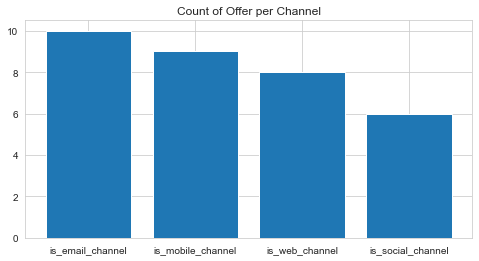

In [145]:
data = portfolio[['is_email_channel','is_mobile_channel','is_social_channel','is_web_channel']].sum().to_frame()
barplot(data=data, title='Count of Offer per Channel')

According to the above graph, all offers have been sent via email channel and the least channel used is social.

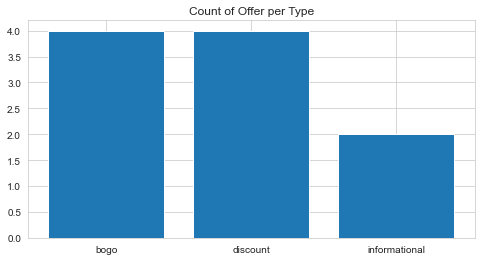

In [146]:
data = portfolio.groupby(by=['offer_type'])[['id']].count()
barplot(data=data, title='Count of Offer per Type')

The informational is the least type for offers while the discount and bogo have a same number by 4 respectively.

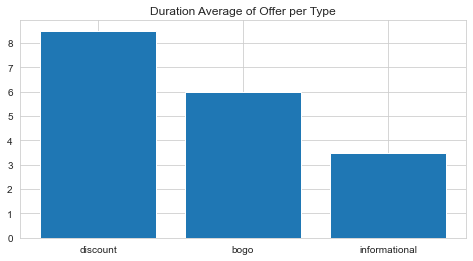

In [147]:
data = portfolio.groupby(by=['offer_type'])[['duration']].mean()
barplot(data=data, title='Duration Average of Offer per Type')

As a shown above, the average of duration depends on offer type since the discount has the highest average which is around 8.5 days while the bogo has 6 days.

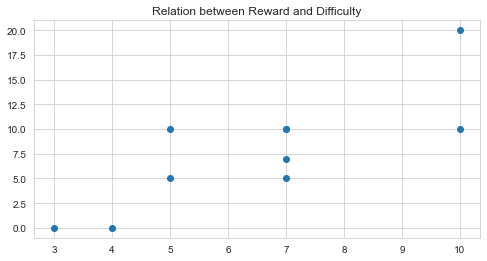

In [148]:
plt.figure(figsize=(8,4))
plt.title('Relation between Reward and Difficulty')
plt.scatter(portfolio.duration,portfolio.difficulty)
# Save the plot as an image
plt.savefig('fig\Relation between Reward and Difficulty.jpg', bbox_inches = 'tight')
plt.show();

As a shown scatter plot, there is good relation between reward and difficutly due to the increasing of difficulty lead to higher rewards.

##### Profile Dataset

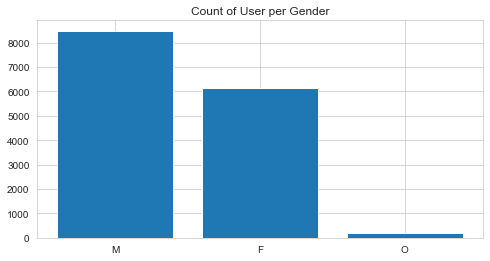

In [149]:
data = profile.groupby(by=['gender'])[['id']].count()
barplot(data=data, title='Count of User per Gender')

Regrad to the bar plot, the male is the most gender of registered person by more than 8,000 users while the female comes in the second rank by around 6,000 users. However, there were users who selected 'Others' by around 200.

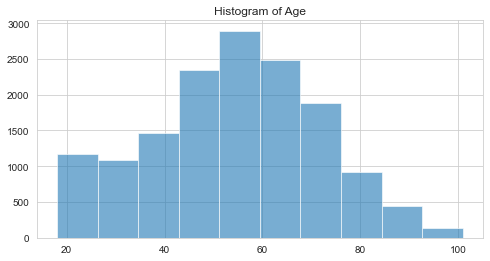

In [150]:
plt.figure(figsize=(8,4))
plt.title('Histogram of Age')
plt.hist(profile.age,bins=10,alpha=0.6)
plt.savefig('fig\Histogram of Age.jpg', bbox_inches = 'tight')
plt.show();

To the shown histogram, the age of user are normal distributed. Thus, the most of user age are between 65 and 73 years.

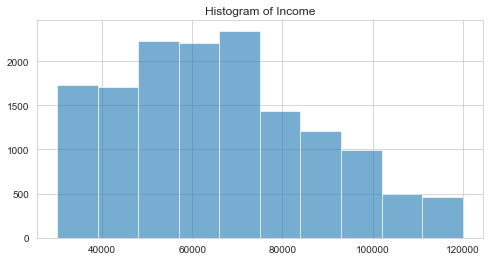

In [151]:
plt.figure(figsize=(8,4))
plt.title('Histogram of Income')
plt.hist(profile.income,bins=10,alpha=0.6)
plt.savefig('fig\Histogram of Income.jpg', bbox_inches = 'tight')
plt.show();

According to the above plot, the income is right skewed. Thus, the most of user income is below 70,000 USD.

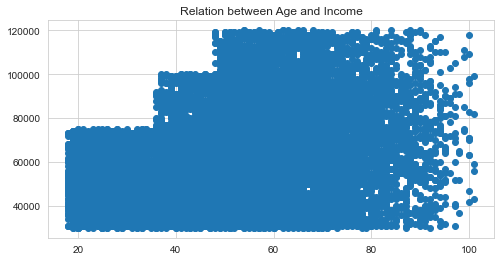

In [152]:
plt.figure(figsize=(8,4))
plt.title('Relation between Age and Income')
plt.scatter(profile.age,profile.income)
plt.savefig('fig\Relation between Age and Income.jpg', bbox_inches = 'tight')
plt.show();

As a shown scatter plot, there is no strong correlation between `Age` and `Income`.

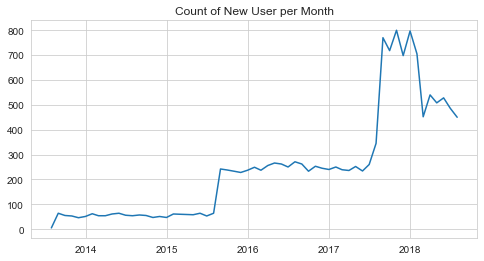

In [153]:
data = profile.groupby(pd.Grouper(key='became_member_on',axis=0,freq='M'))[['id']].count()
plt.figure(figsize=(8,4))
plt.title('Count of New User per Month')
plt.plot(data.index,data.id);
plt.savefig('fig\Count of New User per Month.jpg', bbox_inches = 'tight')

The line plot has shown that the number of new users increased yearly in general. Also, the mid of 2015 had the first jump of number from around 60 to 250 until the end of year. The highest numbers of new users are in the second half of 2017 by 760 one time and 800 twice.

##### Transcript Dataset

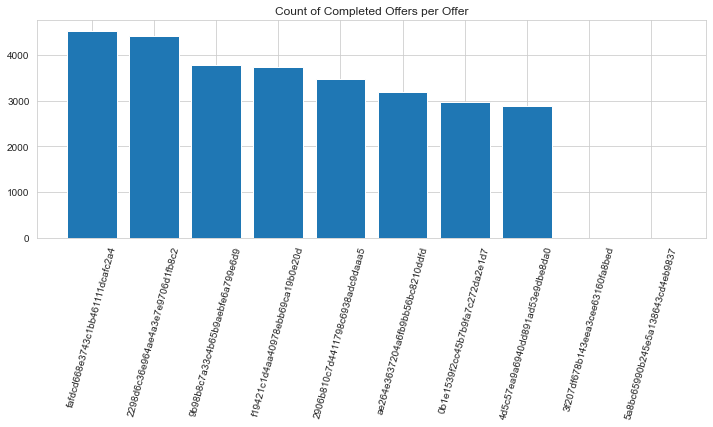

In [154]:
data = transcript.groupby(by=['offer_id'])[['is_offer_completed']].sum()
barplot(data=data, title='Count of Completed Offers per Offer', width=12, height=4, rotation=75)

According to the above graph, the number of completed offer passed 2800 at least per offer except two offers which have no completed offers ever. However, the top 2 offers are so closed to each other by around 100 as a difference.  

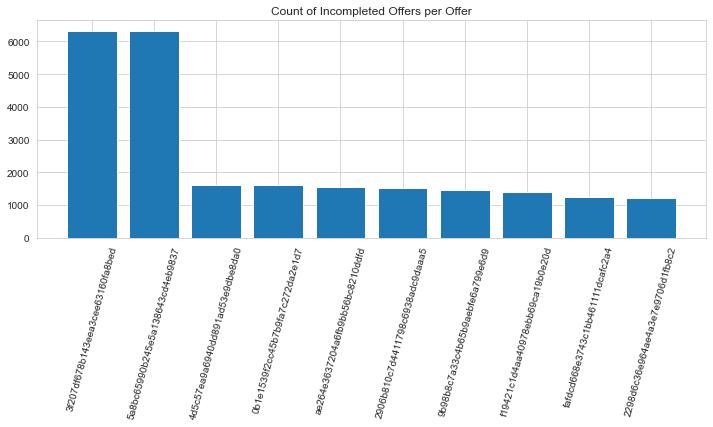

In [155]:
data = transcript[transcript['is_offer_completed']==0].groupby(by=['offer_id'])[['is_offer_completed']].count()
barplot(data=data, title='Count of Incompleted Offers per Offer', rotation=75, width=12, height=4)

Respect to the shown plot, it has shown a contrary pattern to the pervious graph of `Count of Completed Offers per Offer` because of the top 2 offers in this plot are expected to be like that since they do have any completed offer. Also, the rest offers show a low numbers compared to the highest number here.

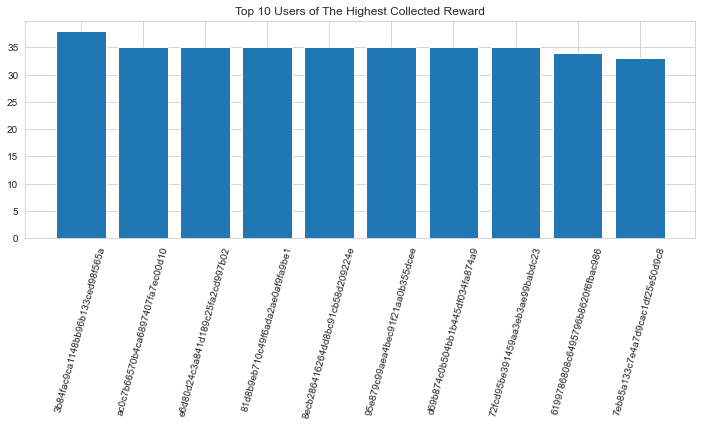

In [156]:
data = transcript[transcript['is_offer_completed']==1].groupby(by=['person'])[['reward']].sum()
data = data.sort_values(['reward'],ascending=False).head(10)
barplot(data=data, title='Top 10 Users of The Highest Collected Reward', rotation=75, width=12, height=4)

According to the presented plot, the collected reward of top 10 users are almost close to each other where the maximum differenec between them is 3. Also, most of top 10 users has collected 35 while the first user has 35.5. To illustrate, thoes users are so interactive to offers since they almost have the same number of collected reward.

#### Map Person and Offer to Numeric ID

In [158]:
portfolio['id'] = portfolio.id.apply(lambda x: list(offer_ids_dict.values()).index(x))

In [159]:
profile['id'] = profile.id.apply(lambda x: list(profile_ids_dict.values()).index(x))

In [160]:
transcript['person'] = transcript.person.apply(lambda x: list(profile_ids_dict.values()).index(x))
transcript['offer_id'] = transcript.offer_id.apply(lambda x: list(offer_ids_dict.values()).index(x))

##### Merged Dataset

In [161]:
profile = profile.rename(columns={'id':'person_id'})
profile.head()

,gender,age,person_id,became_member_on,income
1,F,55,9161,2017-07-15,112000.0
3,F,75,4182,2017-05-09,100000.0
5,M,68,2071,2018-04-26,70000.0
8,M,65,9341,2018-02-09,53000.0
12,M,58,4523,2017-11-11,51000.0


In [162]:
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio.head()

,reward,is_web_channel,is_mobile_channel,is_social_channel,is_email_channel,difficulty,duration,offer_type,offer_id
0,10,0,1,1,1,10,7,bogo,9
1,10,1,1,1,1,10,5,bogo,8
2,0,1,1,0,1,0,4,informational,4
3,5,1,1,0,1,5,7,bogo,3
4,5,1,0,0,1,20,10,discount,0


In [163]:
transcript = transcript.rename(columns={'person':'person_id'})
transcript.head()

,person_id,is_offer_completed,time,offer_id,reward
4,9142,0,0,8,10
7,4523,0,0,4,0
10,8290,0,0,0,5
11,16690,0,0,0,5
27,10482,0,0,9,10


In [164]:
transcript_profile = pd.merge(transcript,profile,on='person_id')
raw_df = pd.merge(transcript_profile,portfolio,on='offer_id')
raw_df.drop(['reward_y'],axis=1,inplace=True)
raw_df.head()

,person_id,is_offer_completed,time,offer_id,reward_x,gender,age,became_member_on,income,is_web_channel,is_mobile_channel,is_social_channel,is_email_channel,difficulty,duration,offer_type
0,4523,0,0,4,0,M,58,2017-11-11,51000.0,1,1,0,1,0,4,informational
1,13706,0,504,4,0,M,39,2014-05-27,51000.0,1,1,0,1,0,4,informational
2,569,0,0,4,0,F,74,2015-12-24,107000.0,1,1,0,1,0,4,informational
3,11998,0,576,4,0,M,45,2017-08-15,54000.0,1,1,0,1,0,4,informational
4,10282,0,0,4,0,M,71,2017-01-29,57000.0,1,1,0,1,0,4,informational


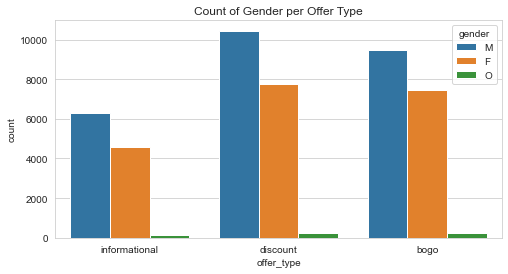

In [165]:
fig = plt.figure(figsize=(8,4))
sns.countplot(x='offer_type',hue='gender',data=raw_df)
plt.title('Count of Gender per Offer Type')
plt.savefig('fig\Count of Gender per Offer Type.jpg', bbox_inches = 'tight')
plt.show();

As a shown bar plot, the most sent type of offer is discount where we have found the highest number of each gender type on it. Moreover, the male reachs more than 10,000 which a big number compared to other type of offer. However, the female has same behavior in discount and bogo types unlike male.

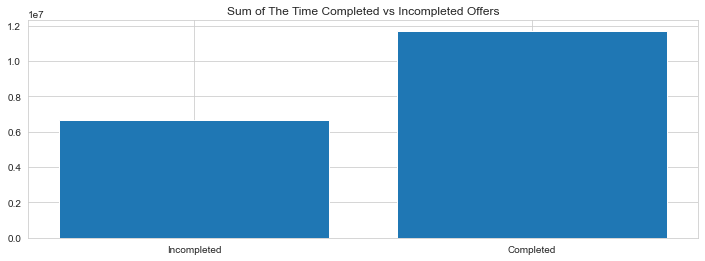

In [166]:
data = raw_df.groupby(by=['is_offer_completed'])[['time']].sum()
plt.figure(figsize=(12,4))
plt.title('Sum of The Time Completed vs Incompleted Offers')
plt.bar(list(map(str,data.index)),data.iloc[:,0].values)
plt.xticks([0,1],['Incompleted','Completed'])
plt.savefig('fig\Sum of The Time Completed vs Incompleted Offers.jpg', bbox_inches = 'tight')
plt.show();

Regrad to the above plot, the completed offers have consumed a double time of incompleted offer. In other words, users perfer to take amount of time to complete like reading the details and ask their friends about the offer itself if they are really interseted.

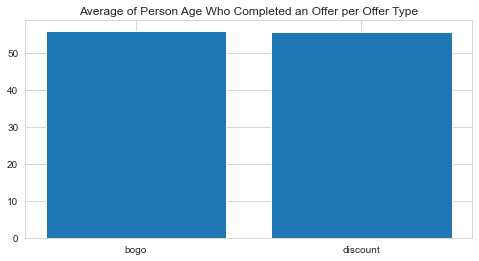

In [167]:
data = raw_df[raw_df.is_offer_completed==1].groupby(by=['offer_type'])[['age']].mean()
barplot(data=data,title='Average of Person Age Who Completed an Offer per Offer Type')

This bar plot shows the shared pattern between bogo and discount since we have almost same age average of users who completed their per type. Moreover, the most of users have a good experience in offer over their life as they are getting older.

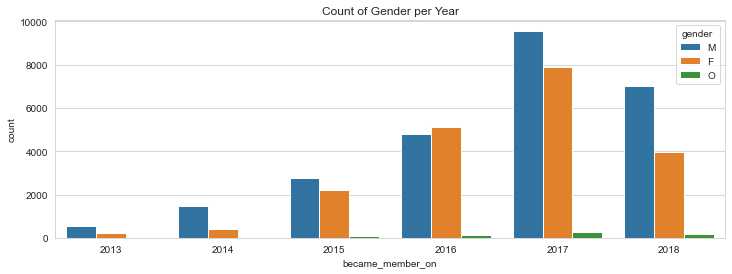

In [168]:
# change the format from yyyy-mm-dd to yyyy
raw_df['became_member_on'] = pd.DatetimeIndex(raw_df['became_member_on']).year

fig = plt.figure(figsize=(12,4))
sns.countplot(x='became_member_on',hue='gender',data=raw_df)
plt.title('Count of Gender per Year')
plt.savefig('fig\Count of Gender per Year.jpg', bbox_inches = 'tight')
plt.show();

Regrad to the show graph, the gender of new user is most likely male in general over the past year. In 2015, the number of new feamle user has been rocketed by around 2,000 compared to 2014. The following years, the male was the leader except 2016 and the highest number of new male user was between 9,700 and 9,800 in 2017. The 'other' type of gender appeared since 2015 with a small number.

### Building Models

#### One-Hot Encoding
This process is required to prepare the categorical type for modeling

In [65]:
raw_df['is_male'] = raw_df.gender.apply(lambda x: 1 if x == 'M' else 0)
raw_df['is_female'] = raw_df.gender.apply(lambda x: 1 if x == 'F' else 0)
raw_df['is_discount'] = raw_df.offer_type.apply(lambda x: 1 if x == 'discount' else 0)
raw_df['is_bogo'] = raw_df.offer_type.apply(lambda x: 1 if x == 'bogo' else 0)

In [66]:
# because the most of new users are after 2015, we decide to map became_member_on into 1's if year after 2015 or 0's
raw_df['is_after2015'] = raw_df.became_member_on.apply(lambda x: 1 if x > 2015 else 0)

In [67]:
# drop the used columns in one-hot encoding
cleaned_raw_df = raw_df.drop(['person_id','gender','offer_type','offer_id','became_member_on'],axis=1)

In [108]:
cleaned_raw_df.head()

,is_offer_completed,time,reward_x,age,income,is_web_channel,is_mobile_channel,is_social_channel,is_email_channel,difficulty,duration,is_male,is_female,is_discount,is_bogo,is_after2015
0,0,0,0,58,51000.0,1,1,0,1,0,4,1,0,0,0,1
1,0,504,0,39,51000.0,1,1,0,1,0,4,1,0,0,0,0
2,0,0,0,74,107000.0,1,1,0,1,0,4,0,1,0,0,0
3,0,576,0,45,54000.0,1,1,0,1,0,4,1,0,0,0,1
4,0,0,0,71,57000.0,1,1,0,1,0,4,1,0,0,0,1


### 70-30 Train/Test Split

In [68]:
# select all features for dataset
X = cleaned_raw_df.iloc[:,1:]

# select the target feature for dataset
y = cleaned_raw_df.iloc[:,0]

In [69]:
# define the train and test datasets with the test_size 0.3 and random state 5
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=5)

In [70]:
# Do Scaling for data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [169]:
def build_model(model,model_name,y_test=y_test,y_train=y_train):
    """
    INPUT:
    model - (Dataframe) a model
    model_name - (Str) a name of model
  
    OUTPUT:
    accuracy_score_train - (int) an accuracy score for train dataset
    accuracy_score_test - (int) an accuracy score for test dataset
    """
    
    # Fit train data into model
    model.fit(Xs_train, y_train)

    # Predict y train and test
    y_pred_train = model.predict(Xs_train)
    y_pred_test = model.predict(Xs_test)

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Test Confusion Matrix of - '+model_name)
    plt.savefig('fig\\Test Confusion Matrix of - '+model_name+'.jpg', bbox_inches = 'tight')
    plt.show()
    
    print("Train Accuracy Score of "+model_name+f": {accuracy_score(y_train,y_pred_train)}")
    print("Test Accuracy Score of "+model_name+f": {accuracy_score(y_test,y_pred_test)}")

    return accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)

### Logistic Regression

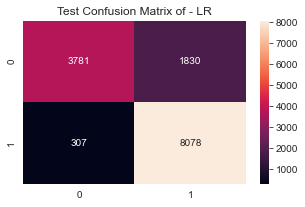

Train Accuracy Score of LR: 0.8467709832501454
Test Accuracy Score of LR: 0.8473135181480423


In [119]:
# instantiate Logistic Regression Model
lr = LogisticRegression()

# build the model and get accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(lr,"LR")

# define the dictionaries of train and test scores
train_score = {}
test_score = {}

train_score['LR'] = accuracy_score_train
test_score['LR'] = accuracy_score_test

#### K-Nearest Neighbors

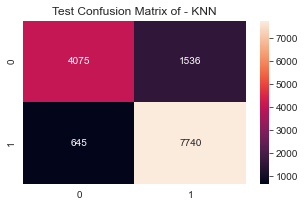

Train Accuracy Score of KNN: 0.8779740943748661
Test Accuracy Score of KNN: 0.8441697627893684


In [120]:
# instantiate KNN Model
knn = KNeighborsClassifier(n_neighbors=7)

# build the model and get accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(knn,"KNN")

train_score['KNN'] = accuracy_score_train
test_score['KNN'] = accuracy_score_test

#### Decision Tree

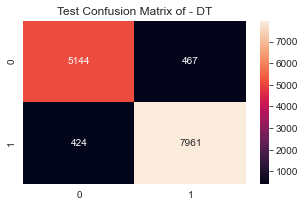

Train Accuracy Score of DT: 0.9994794377928162
Test Accuracy Score of DT: 0.9363389539868534


In [121]:
# Instantiate DT Model
dt = DecisionTreeClassifier()

# build the model and get accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(dt,"DT")

train_score['DT'] = accuracy_score_train
test_score['DT'] = accuracy_score_test

#### Support Vector Machine

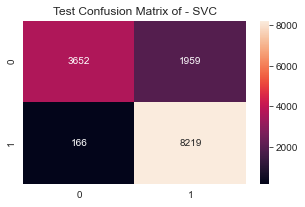

Train Accuracy Score of SVC: 0.8470159537005849
Test Accuracy Score of SVC: 0.8481709059731352


In [122]:
# Instantiate SVC Model
svc = SVC()

# build the model and get accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(svc,"SVC")

train_score['SVC'] = accuracy_score_train
test_score['SVC'] = accuracy_score_test

#### Random Forest

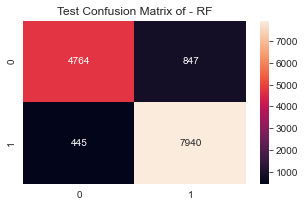

Train Accuracy Score of RF: 0.9994488164865113
Test Accuracy Score of RF: 0.9076879108316662


In [123]:
# Instantiate RF Model
rf = RandomForestClassifier()

# build the model and get accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(rf,"RF")

train_score['RF'] = accuracy_score_train
test_score['RF'] = accuracy_score_test

#### Model Summary

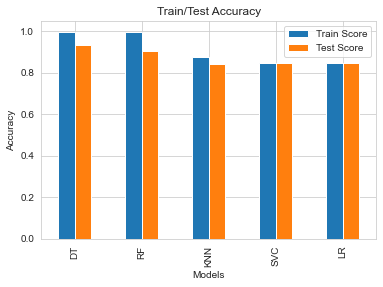

In [175]:
# Define dataframes has the all model with their train and test scores
score_df = pd.DataFrame({'Models':train_score.keys(),'Train Score':train_score.values(),'Test Score':test_score.values()})
score_df.sort_values('Train Score',ascending=False).\
plot(kind='bar',x='Models',y=['Train Score','Test Score'],title='Train/Test Accuracy',ylabel='Accuracy');
plt.savefig('fig\Train_Test Accuracy.jpg', bbox_inches = 'tight')

According to the above graph, we have developed a model to predict the offer will be completed or not by many models. From an accuracy perspective, all models perform well since the lowest accuracy was 84.4%, as well as `Decision Tree`, `Random Forest` and `K-Nearest Neighbors`, have an overfitting problem. In other words, those models perform well in train-set while in test-set produce more errors in test-set (unseen data). Thus, we will do tuning parameters for them, try different train-test split sizes to tackle this issue and do feature selection to find the optimal set of features.

### Conclusion

Starbucks is a well-known company in the food and beverage industry specifically in coffee. To sum up amazing findings, the number of clients in the app has been rapidly in 2016 and 2017. Also, the users who spend more time on the offer, are more likely to complete the offer. The most of new or old users are male and they are interactive with discount offers mainly while the female has the same attitude against discount and BOGO types. Also, email is the most effective channel to send offers. The discount offer is featured for a long duration compared to the other types.

In the machine learning part, I have developed a model that predicts users will complete the offer or not to support the marketing team for selecting the high potential clients. The cost of finding an influenced customer will be reduced.

The next step will be to develop an interactive website to predict whether a user will complete the offer or not in order to get a benefit from the model.